# Predictive Analysis of New York City's Electricity Consumption Using XGBoost for Time Series Forecasting

# Part-1

# Data Preparation

In [1]:
import pandas as pd
import numpy as np
from prophet import Prophet
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df = pd.read_csv("Electric_Consumption_And_Cost__2010_-_Feb_2023__20231215.csv",low_memory=False)

In [3]:
df.head(3)

,Development Name,Borough,Account Name,Location,Meter AMR,Meter Scope,TDS #,EDP,RC Code,Funding Source,...,Meter Number,Estimated,Current Charges,Rate Class,Bill Analyzed,Consumption (KWH),KWH Charges,Consumption (KW),KW Charges,Other charges
0,ADAMS,BRONX,ADAMS,BLD 05,NONE,BLD 01 to 07,118.0,248,B011800,FEDERAL,...,7223256,N,15396.82,GOV/NYC/068,Yes,128800.0,7387.97,216.0,2808.0,5200.85
1,ADAMS,BRONX,ADAMS,BLD 05,NONE,BLD 01 to 07,118.0,248,B011800,FEDERAL,...,7223256,N,14556.34,GOV/NYC/068,Yes,115200.0,6607.87,224.0,2912.0,5036.47
2,ADAMS,BRONX,ADAMS,BLD 05,NONE,BLD 01 to 07,118.0,248,B011800,FEDERAL,...,7223256,N,13904.98,GOV/NYC/068,Yes,103200.0,5919.55,216.0,2808.0,5177.43


In [4]:
df = df.sort_values('Revenue Month')

In [5]:
df['Revenue Month'] = pd.to_datetime(df['Revenue Month'])

In [6]:
df_m = df[['Borough','Consumption (KWH)','Revenue Month']]

# Summary Statistics: Dataset Overview

#### Visualization - Plotting Electricity Consumption Over Time - Entire dataset

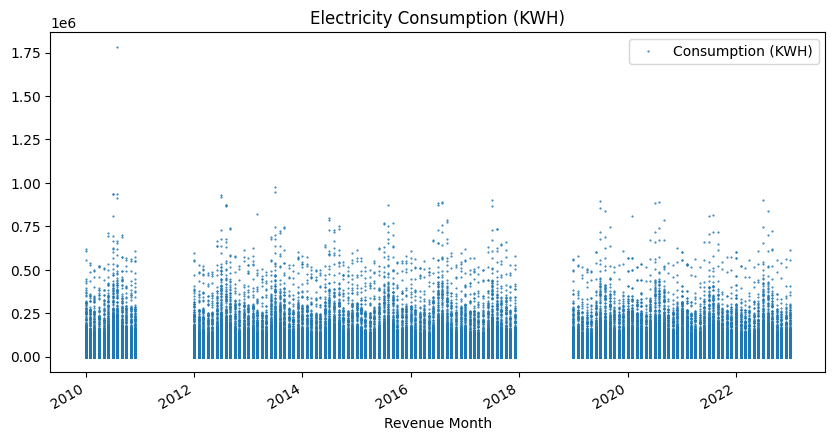

In [7]:
color_pal = sns.color_palette()
df_m.plot(style='.',
         x = 'Revenue Month',
         y='Consumption (KWH)',
          figsize=(10, 5),
          ms=1,
          color=color_pal[0],
          title='Electricity Consumption (KWH)')
plt.show()

####  Visualization - Plotting Electricity Consumption Over Time - for each Borough

In [8]:
def plot_borough(df):
    boroughs = df['Borough'].unique()
    for borough in boroughs:
        borough_df = df[df['Borough'] == borough]
        plt.plot(borough_df['Revenue Month'], borough_df['Consumption (KWH)'], label=borough)
        plt.xlabel('Revenue Month')
        plt.ylabel('Consumption (KWH)')
        plt.title(f'{borough} plot')
        plt.legend()
        plt.show()

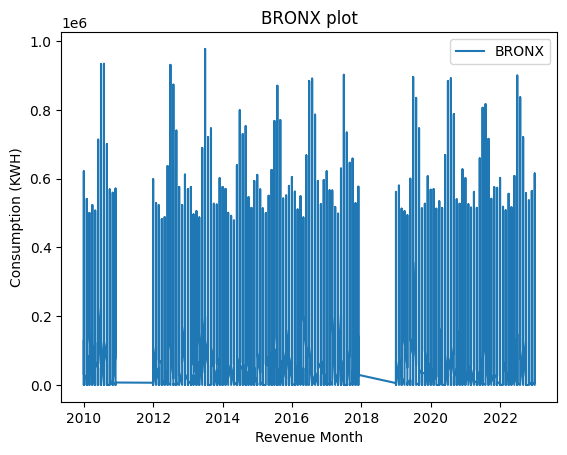

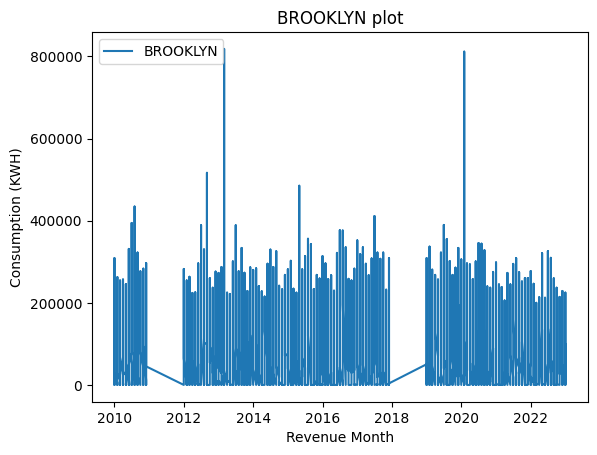

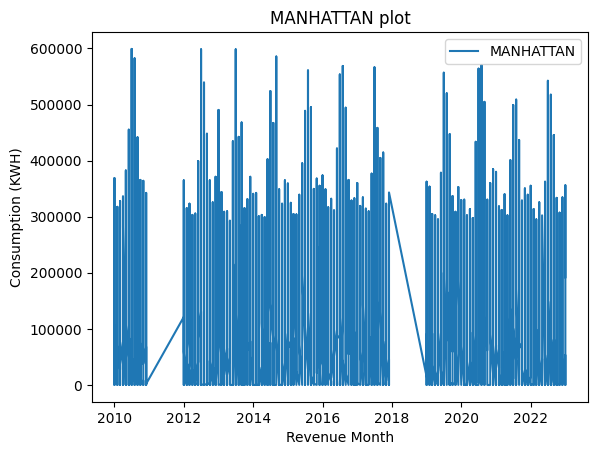

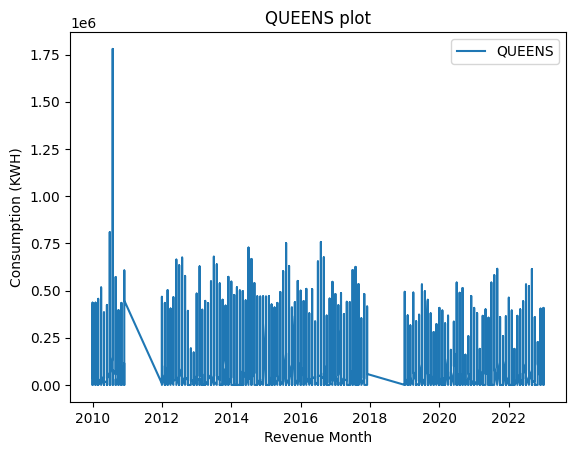

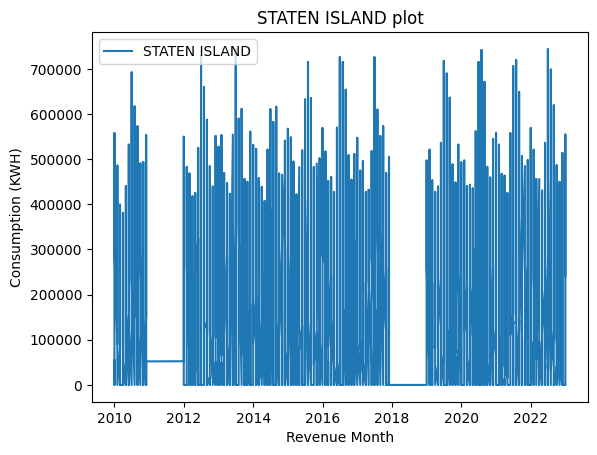

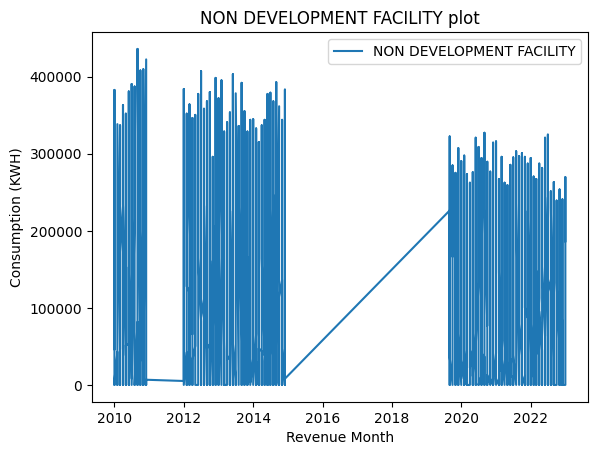

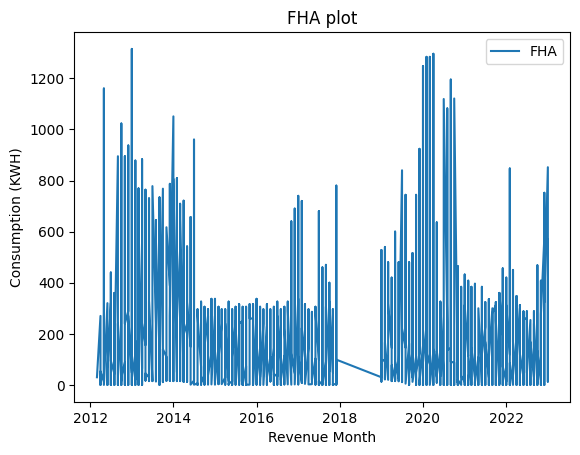

In [9]:
plot_borough(df_m)

In [10]:
x = df_m
x['Month'] = df_m['Revenue Month'].dt.month

/var/folders/lh/cswt7s450g10kh_jxldflrlc0000gn/T/ipykernel_2139/2326848721.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['Month'] = df_m['Revenue Month'].dt.month


### Visualizing Monthly Electricity Consumption

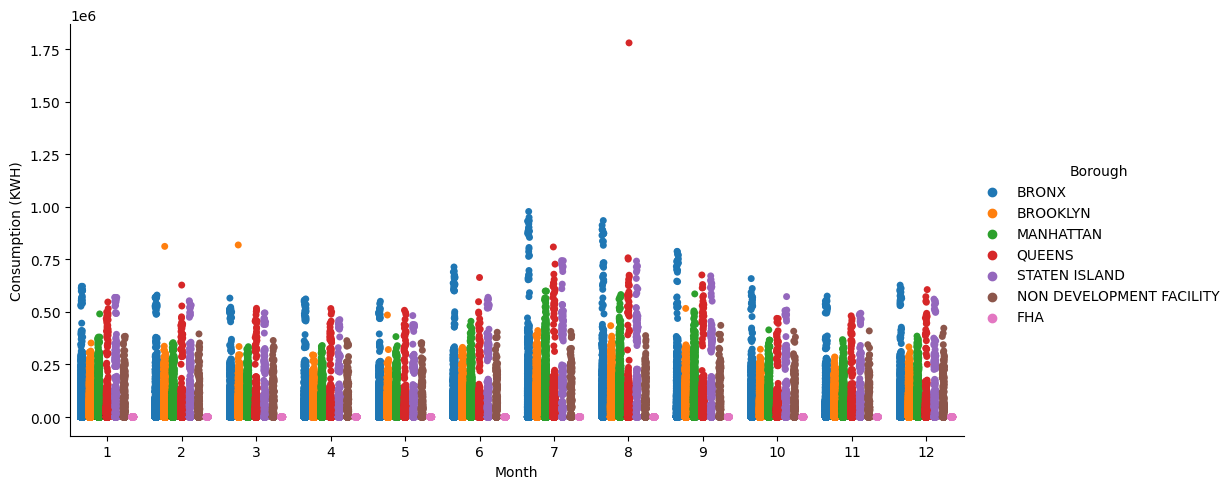

In [11]:
sns.catplot(data=x.dropna(),
            x='Month',
            y='Consumption (KWH)',
            hue = 'Borough',
            dodge=True,
            height=5, aspect=2
           )
plt.show()

## Consolidation into Single Data Point per Month and its visualization

In [12]:
df_monthly= pd.DataFrame()
df_monthly['ds'] = df_m['Revenue Month']
df_monthly['y'] = df_m[['Consumption (KWH)', 'Revenue Month' ]].groupby('Revenue Month').transform('mean')

In [13]:
df_monthly = df_monthly.drop_duplicates(keep='first')

Text(0.5, 1.0, 'Average Monthly Consumtion over the years')

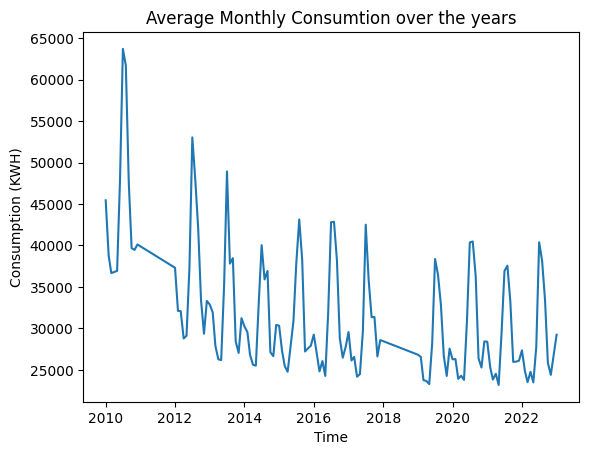

In [14]:
plt.plot( df_monthly['ds'], df_monthly['y'])
plt.xlabel('Time')
plt.ylabel('Consumption (KWH)')
plt.title('Average Monthly Consumtion over the years')

In [15]:
df_monthly = df_monthly.set_index('ds')
df_monthly

,y
ds,
2010-01-01,45446.030782
2010-02-01,38808.144583
2010-03-01,36667.210941
2010-04-01,36808.514463
2010-05-01,36933.632880
...,...
2022-09-01,33448.128492
2022-10-01,25837.228076
2022-11-01,24391.869086


# Part-2

# Train Test Split

In [16]:
train = df_monthly.loc[df_monthly.index.year < 2021]
test = df_monthly.loc[df_monthly.index.year >= 2021]


#### Train/Test Split Comparison with Data Over Time (2021 Boundary)

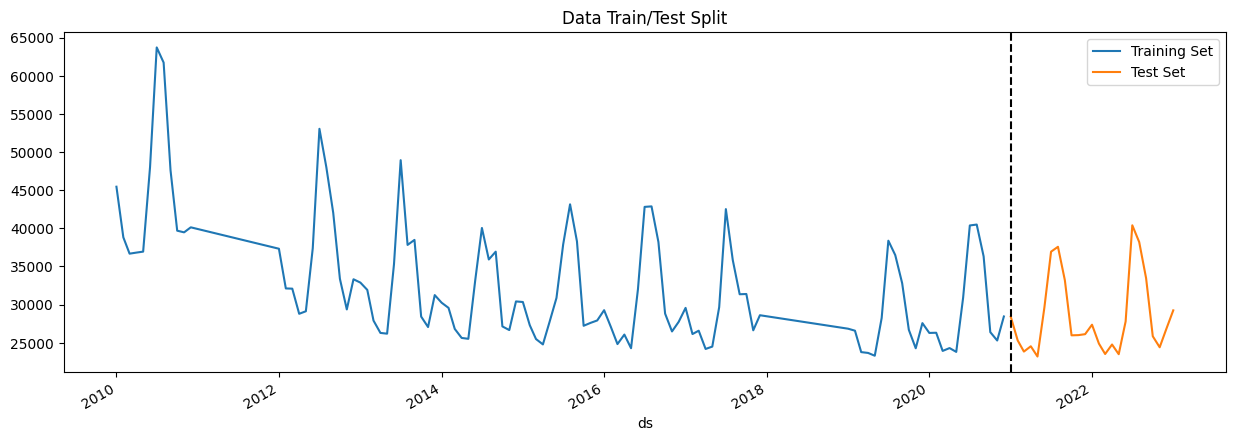

In [17]:
fig, ax = plt.subplots(figsize=(15, 5))
train.plot(ax=ax, label='Training Set', title='Data Train/Test Split')
test.plot(ax=ax, label='Test Set')
ax.axvline('2021', color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()

# Feature Engineering

Feature Engineering involves creating new features or modifying existing ones to improve a model's performance. It aims to extract relevant information from raw data, thereby making it more suitable for machine learning algorithms. 

Extracting features like day, month from timestamps.

#### Converting index to date time for feature generation

In [18]:
df_monthly.index = pd.to_datetime(df_monthly.index)
df_monthly.index.month

Index([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10,
       ...
        4,  5,  6,  7,  8,  9, 10, 11, 12,  1],
      dtype='int32', name='ds', length=133)

#### Adding Date-based Features to Time Series Data

In [19]:
def create_features(df_monthly):
    df_monthly = df_monthly.copy() 
    df_monthly['month'] = df_monthly.index.month
    df_monthly['dayofmonth'] = df_monthly.index.day
    return df_monthly

df_monthly = create_features(df_monthly)
df_monthly

,y,month,dayofmonth
ds,,,
2010-01-01,45446.030782,1,1
2010-02-01,38808.144583,2,1
2010-03-01,36667.210941,3,1
2010-04-01,36808.514463,4,1
2010-05-01,36933.632880,5,1
...,...,...,...
2022-09-01,33448.128492,9,1
2022-10-01,25837.228076,10,1
2022-11-01,24391.869086,11,1


#### Monthly Distribution of KWH (Kilowatt-Hours) via Box Plot

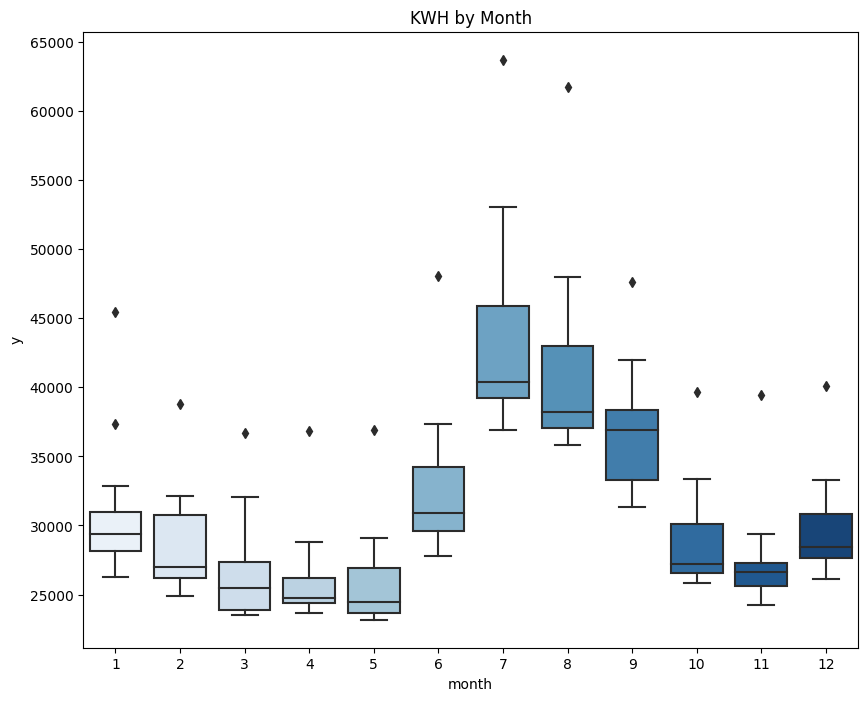

In [20]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df_monthly, x='month', y='y', palette='Blues')
ax.set_title('KWH by Month')
plt.show()

#### Feature Engineering and Data Splitting for Time Series Modeling

Prepared the training and testing datasets by creating specific features ('month' and 'dayofmonth') for both the training and testing sets. 

In [21]:
train = create_features(train)
test = create_features(test)

FEATURES = ['month', 'dayofmonth']
TARGET = 'y'

X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

# XGBoost Regressor Model - Default

In [22]:
reg = xgb.XGBRegressor()
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=100)

[0]	validation_0-rmse:6724.12067	validation_1-rmse:5386.87124


[99]	validation_0-rmse:5180.03424	validation_1-rmse:4319.58462


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

#### Visualizing Feature Importance using Bar Plot

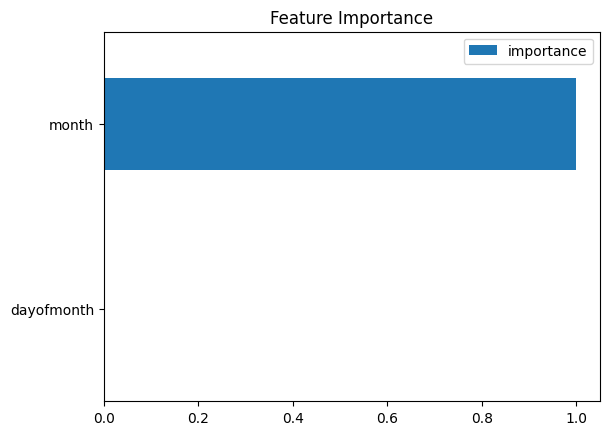

In [23]:
fi_default = pd.DataFrame(data=reg.feature_importances_,
             index=reg.feature_names_in_,
             columns=['importance'])
fi_default.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

#### Visualizing Predictions against Actual Data in Time Series Analysis

In [24]:
test['prediction'] = reg.predict(X_test)

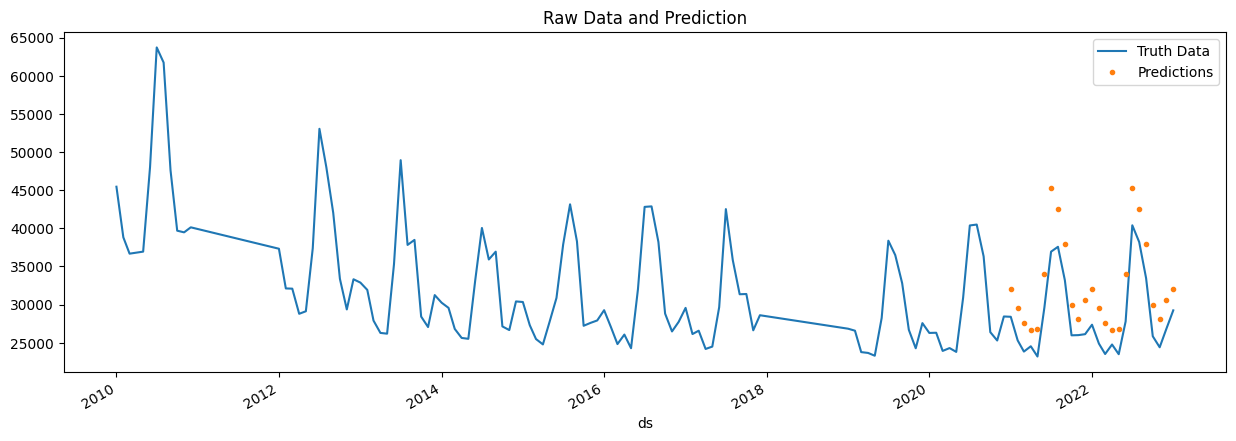

In [25]:
df_monthly = df_monthly.merge(test[['prediction']], how='left', left_index=True, right_index=True)
ax = df_monthly[['y']].plot(figsize=(15, 5))
df_monthly['prediction'].plot(ax=ax, style='.')
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw Data and Prediction')
plt.show()

## Model Evaluation - Default XGBoost Regressor 

In [26]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

score = np.sqrt(mean_squared_error(test['y'], test['prediction']))
r2= r2_score(test['y'], test['prediction'])
mae= mean_absolute_error(test['y'], test['prediction'])
mape=mean_absolute_percentage_error(y_true=test['y'], y_pred=test['prediction'])
print(f'MSE : {score:0.2f}')
print(f'R2 Error : {r2:0.2f}')
print(f'MAE : {mae:0.2f}') 
print(f'MAPE : {mape:0.2f}') 

MSE : 4319.58
R2 Error : 0.27
MAE : 4126.25
MAPE : 14.54


### Top 10 Dates by Mean Absolute Error Evaluation

Evaluating the performance of the model by calculating the mean absolute error for each date in the 'test' dataset after making predictions with the model

In [27]:
test['error'] = np.abs(test[TARGET] - test['prediction'])
test['date'] = test.index.date
test.groupby(['date'])['error'].mean().sort_values(ascending=False).head(10)

date
2021-07-01    8364.529011
2022-06-01    6172.558835
2021-08-01    4904.480807
2022-07-01    4903.423149
2021-09-01    4806.487478
2022-01-01    4661.449000
2022-02-01    4645.458344
2022-09-01    4544.539477
2021-12-01    4477.488288
2021-06-01    4352.123833
Name: error, dtype: float64

# XGBoost Regressor With Tuned Parameters

Specified the booster type as gradient boosted tree and the number of boosting rounds (trees) in the model - it sets the maximum number of trees to 1000.

In [28]:
reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                       n_estimators=1000,
                       early_stopping_rounds=50,
                       objective='reg:squarederror',
                       max_depth=3,
                       learning_rate=0.01)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=100)

[0]	validation_0-rmse:33198.14941	validation_1-rmse:28550.56660
[100]	validation_0-rmse:13548.51573	validation_1-rmse:8421.16552
[200]	validation_0-rmse:7125.71632	validation_1-rmse:1312.73119
[265]	validation_0-rmse:5846.60872	validation_1-rmse:1867.52637


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

#### Visualizing Feature Importance using Bar Plot

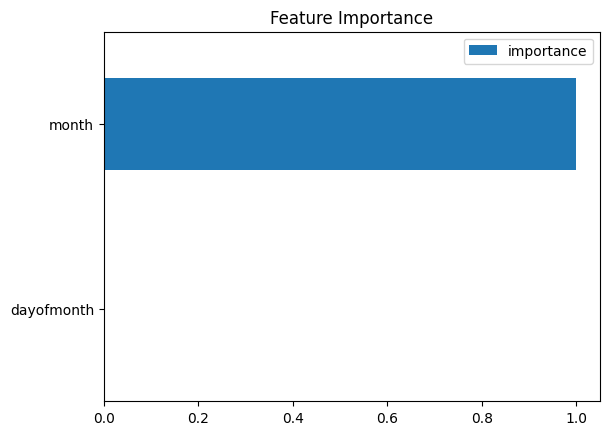

In [29]:
fi = pd.DataFrame(data=reg.feature_importances_,
             index=reg.feature_names_in_,
             columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

#### Visualizing Predictions against Actual Data in Time Series Analysis

In [31]:
test['prediction'] = reg.predict(X_test)


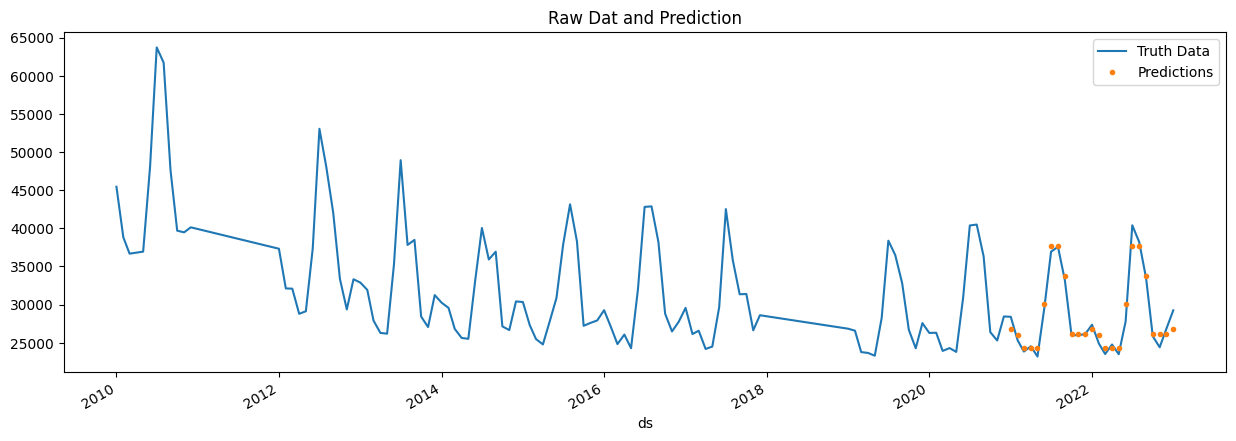

In [32]:
df_monthly = df_monthly.merge(test[['prediction']], how='left', left_index=True, right_index=True)
ax = df_monthly[['y']].plot(figsize=(15, 5))
df_monthly['prediction'].plot(ax=ax, style='.')
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw Dat and Prediction')
plt.show()

## Model Evaluation - XGBoost Regressor with tuned parameters

In [33]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

score = np.sqrt(mean_squared_error(test['y'], test['prediction']))
r2= r2_score(test['y'], test['prediction'])
mae= mean_absolute_error(test['y'], test['prediction'])
mape=mean_absolute_percentage_error(y_true=test['y'], y_pred=test['prediction'])
print(f'MSE : {score:0.2f}')
print(f'R2 Error : {r2:0.2f}')
print(f'MAE : {mae:0.2f}') 
print(f'MAPE : {mape:0.2f}') 

MSE : 1108.82
R2 Error : 0.95
MAE : 832.69
MAPE : 2.95


### Top 10 Dates by Mean Absolute Error Evaluation

Evaluating the performance of the model by calculating the mean absolute error for each date in the 'test' dataset after making predictions with the model

In [34]:
test['error'] = np.abs(test[TARGET] - test['prediction'])
test['date'] = test.index.date
test.groupby(['date'])['error'].mean().sort_values(ascending=False).head(10)

date
2022-07-01    2688.838570
2023-01-01    2429.681297
2022-06-01    2255.519773
2022-11-01    1730.078179
2021-01-01    1586.015923
2021-05-01    1130.870991
2022-02-01    1084.204438
2022-05-01     827.877914
2022-03-01     801.253180
2021-07-01     772.267292
Name: error, dtype: float64

# Part-3

# XGBoost Regression Model Training on "Monthly Data" with Feature Engineering and External factor

Created features from monthly data and training an XGBoost regressor. Defined features and target variables. Segregated features and target from the DataFrame and Initialized and trained the XGBoost regressor

In [35]:
df_monthly_future = create_features(df_monthly)

FEATURES = ['month', 'dayofmonth']
TARGET = 'y'

X_all = df_monthly[FEATURES]
y_all = df_monthly[TARGET]

reg = xgb.XGBRegressor(base_score=0.5,
                       booster='gbtree',    
                       n_estimators=500,
                       objective='reg:linear',
                       max_depth=3,
                       learning_rate=0.01)
reg.fit(X_all, y_all,
        eval_set=[(X_all, y_all)],
        verbose=100)

[0]	validation_0-rmse:32381.25873
[100]	validation_0-rmse:13119.85006
[200]	validation_0-rmse:6835.58624
[300]	validation_0-rmse:5306.32261
[400]	validation_0-rmse:5021.52487
[499]	validation_0-rmse:4974.79488


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [18:17:36] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=500, n_jobs=None,
             num_parallel_tree=None, objective='reg:linear', ...)

# 1 Month in future

Created future date ranges using pd.date_range, a DataFrame with a column indicating future data ('isFuture'), merged this future DataFrame with an existing DataFrame (df_monthly_future), and then generated features using the function create_features applied to the merged DataFrame (df_and_future). 

In [36]:
future_month = pd.date_range('2023-01-01','2023-02-01',periods=2, inclusive='right')
future_df = pd.DataFrame(index=future_month)
future_df['isFuture'] = True
df_monthly_future['isFuture'] = False
df_and_future = pd.concat([df_monthly_future, future_df])
dffuture = create_features(df_and_future)
dffuture

,y,month,dayofmonth,prediction_x,prediction_y,prediction,isFuture
2010-01-01,45446.030782,1,1,NaN,NaN,NaN,False
2010-02-01,38808.144583,2,1,NaN,NaN,NaN,False
2010-03-01,36667.210941,3,1,NaN,NaN,NaN,False
2010-04-01,36808.514463,4,1,NaN,NaN,NaN,False
2010-05-01,36933.632880,5,1,NaN,NaN,NaN,False
...,...,...,...,...,...,...,...
2022-10-01,25837.228076,10,1,29893.705078,29893.705078,26121.947266,False
2022-11-01,24391.869086,11,1,28081.058594,28081.058594,26121.947266,False
2022-12-01,26805.697501,12,1,30588.033203,30588.033203,26121.947266,False
2023-01-01,29234.083641,1,1,32012.423828,32012.423828,26804.402344,False


#### Visualization of Future Predictions for 1 Month

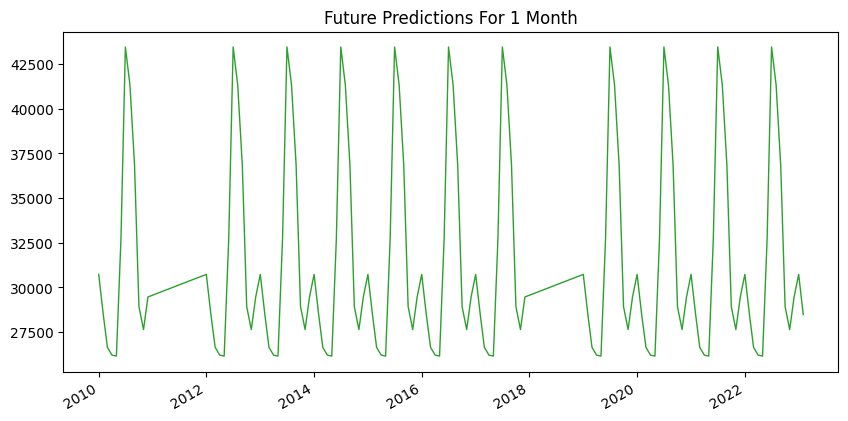

In [37]:
dffuture['pred'] = reg.predict(dffuture[FEATURES])
dffuture['pred'].plot(figsize=(10, 5),
                               color=color_pal[2],
                               ms=1,
                               lw=1,
                               title='Future Predictions For 1 Month')
plt.show()

# 6 Months in future

In [38]:
future_month = pd.date_range('2023-02-01','2023-07-01',freq='MS')
future_df = pd.DataFrame(index=future_month)
future_df['isFuture'] = True
df_monthly_future['isFuture'] = False
df_and_future = pd.concat([df_monthly_future, future_df])
dffuture = create_features(df_and_future)

#### Visualization of Future Predictions for 6 Months

<Axes: title={'center': 'Future Predictions For 6 Months'}>

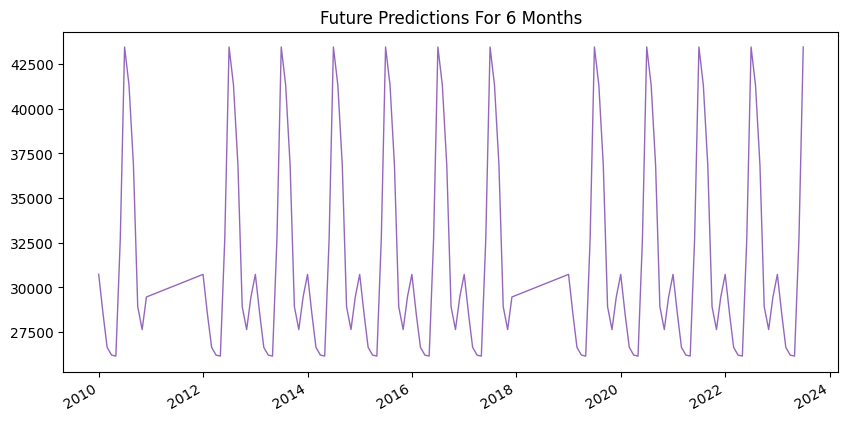

In [39]:
dffuture['pred'] = reg.predict(dffuture[FEATURES])
dffuture['pred'].plot(figsize=(10, 5),
                               color=color_pal[4],
                               ms=1,
                               lw=1,
                               title='Future Predictions For 6 Months')

# 9 Months in future

In [40]:
future_month = pd.date_range('2023-02-01','2023-10-01',freq='MS')
future_df = pd.DataFrame(index=future_month)
future_df['isFuture'] = True
df_monthly_future['isFuture'] = False
df_and_future = pd.concat([df_monthly_future, future_df])
dffuture = create_features(df_and_future)

#### Visualization of Future Predictions for 9 Months

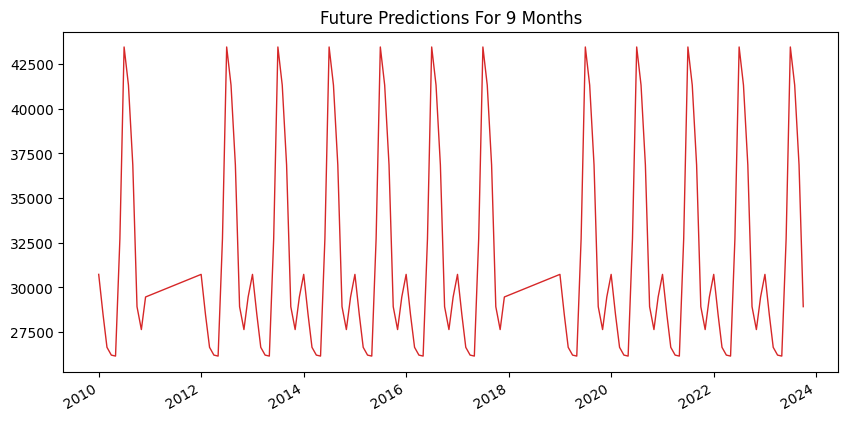

In [41]:
dffuture['pred'] = reg.predict(dffuture[FEATURES])
dffuture['pred'].plot(figsize=(10, 5),
                               color=color_pal[3],
                               ms=1,
                               lw=1,
                               title='Future Predictions For 9 Months')
plt.show()

# Adding Temprature Data to Original Monthly data Frame

 Prepared a DataFrame df_monthly_temprature that combines the monthly revenue data with corresponding temperature values. 

In [42]:
df_monthly_temprature= pd.DataFrame()
df_monthly_temprature['ds'] = df_m['Revenue Month']
df_monthly_temprature['y'] = df_m[['Consumption (KWH)', 'Revenue Month' ]].groupby('Revenue Month').transform('mean')
df_monthly_temprature = df_monthly_temprature.drop_duplicates(keep='first')

In [43]:
df_monthly_temprature['temp'] = [32.1,33.1,47.1,55.4,63.9,74.5,80.7,76.2,70.5,58.5,47.9,33,37.2,40.3,48.5,54.1,64,70.8,78.4,76.7,69.2,59.1,43.6,41.7,35,34,40,50.7,59.9,70.4,79.5,74.4,67.1,60,45.3,38.1,28.6,31.1,37.4,50.1,62.5,71.6,75.5,74.1,69.7,59.8,45.1,41.4,30.7,24.5,37.8,52.6,64.2,71.2,78.4,78.5,73,57.8,52.5,50.3,34.6,37.6,47.5,51,60.3,71.9,78.6,78.9,71.1,58.9,50.6,39.6,38.6,40.3,39.3,55.1,60.5,70.9,76.4,74.6,70.6,63.2,46.1,35,32.4,35.3,40,52.7,60.5,70.7,78.8,75.3,69.4,59.5,43.3,38.1,38.7,39.3,46.5,48.6,58.2,71.5,79.3,76.3,68.4,58.2,50.9,38.5,4.8,33.2,44,51.9,61.3,71.4,75.8,76.9,70.7,63,46.3,43.4,30.3,35.6,43.3,51.0,62.2,70.3,79.3,78.7,70.3,57.1,50.2,37.5,41.8]

#### Time Series Plot: Average Monthly Temperature Trends

Text(0.5, 1.0, 'Average Monthly temprature over the years')

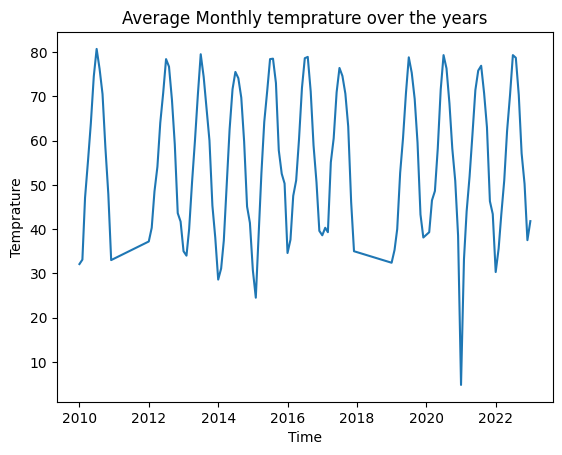

In [44]:
plt.plot( df_monthly_temprature['ds'], df_monthly_temprature['temp'])
plt.xlabel('Time')
plt.ylabel('Temprature')
plt.title('Average Monthly temprature over the years')

Setting the 'ds' column as the index for the DataFrame to facilitate time-based operations

In [45]:
df_monthly_temprature = df_monthly_temprature.set_index('ds')
df_monthly_temprature

,y,temp
ds,,
2010-01-01,45446.030782,32.1
2010-02-01,38808.144583,33.1
2010-03-01,36667.210941,47.1
2010-04-01,36808.514463,55.4
2010-05-01,36933.632880,63.9
...,...,...
2022-09-01,33448.128492,70.3
2022-10-01,25837.228076,57.1
2022-11-01,24391.869086,50.2


#### Train-Test Split

In [46]:
train_temp = df_monthly_temprature.loc[df_monthly_temprature.index.year < 2021]
test_temp = df_monthly_temprature.loc[df_monthly_temprature.index.year >= 2021]

#### Visualization of Train/Test Split for Temperature Data

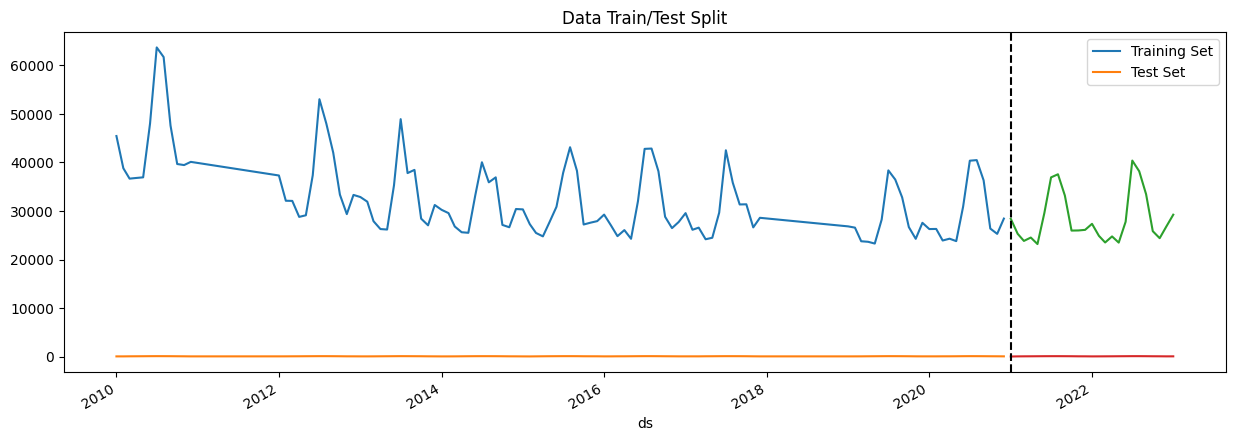

In [47]:
fig, ax = plt.subplots(figsize=(15, 5))
train_temp.plot(ax=ax, label='Training Set', title='Data Train/Test Split')
test_temp.plot(ax=ax, label='Test Set')
ax.axvline('2021', color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()

# Feature Engineering

#### Converting Index to DateTime and Extracting Months for Temperature Data

In [48]:
df_monthly_temprature.index = pd.to_datetime(df_monthly_temprature.index)
df_monthly_temprature.index.month

Index([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10,
       ...
        4,  5,  6,  7,  8,  9, 10, 11, 12,  1],
      dtype='int32', name='ds', length=133)

#### Adding Date-Based Features to Monthly Temperature Data

In [49]:
def create_features_temprature(df_monthly_temprature):
    df_monthly_temprature = df_monthly_temprature.copy() 
    df_monthly_temprature['month'] = df_monthly_temprature.index.month
    df_monthly_temprature['dayofmonth'] = df_monthly_temprature.index.day
    return df_monthly_temprature

df_monthly_temprature = create_features_temprature(df_monthly_temprature)
df_monthly_temprature

,y,temp,month,dayofmonth
ds,,,,
2010-01-01,45446.030782,32.1,1,1
2010-02-01,38808.144583,33.1,2,1
2010-03-01,36667.210941,47.1,3,1
2010-04-01,36808.514463,55.4,4,1
2010-05-01,36933.632880,63.9,5,1
...,...,...,...,...
2022-09-01,33448.128492,70.3,9,1
2022-10-01,25837.228076,57.1,10,1
2022-11-01,24391.869086,50.2,11,1


#### Temperature Variation by Month

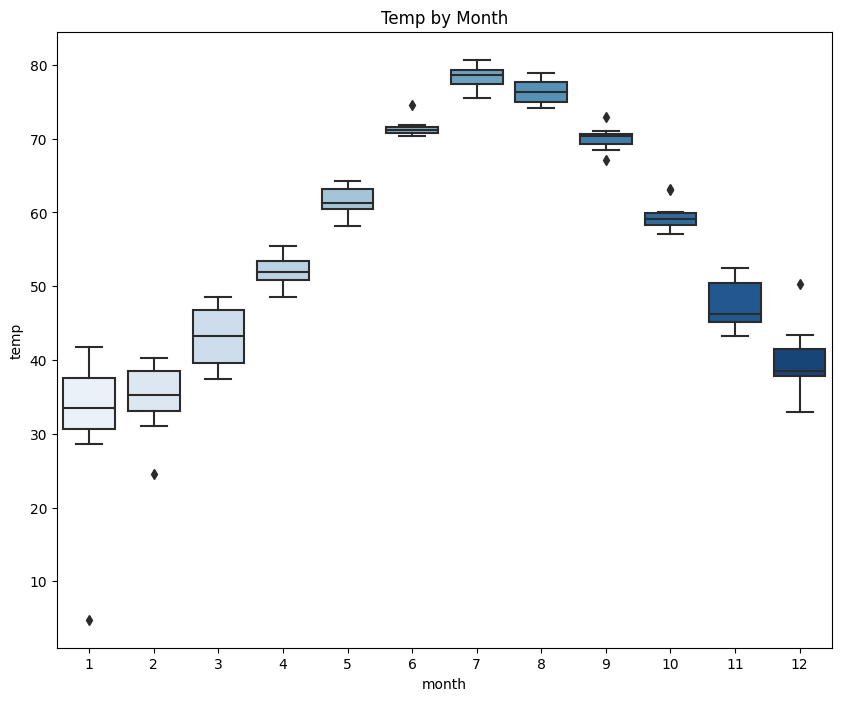

In [50]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df_monthly_temprature, x='month', y='temp', palette='Blues')
ax.set_title('Temp by Month')
plt.show()

#### Feature Engineering for Temperature-Based Modeling

In [51]:
train_temp = create_features_temprature(train_temp)
test_temp = create_features_temprature(test_temp)

FEATURES_TEMP = ['month', 'dayofmonth','temp']
TARGET_TEMP = 'y'

X_train_temp = train_temp[FEATURES_TEMP]
y_train_temp = train_temp[TARGET_TEMP]

X_test_temp = test_temp[FEATURES_TEMP]
y_test_temp = test_temp[TARGET_TEMP]

#### Training XGBoost Regressor

In [52]:
reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                       n_estimators=1000,
                       early_stopping_rounds=50,
                       objective='reg:squarederror',
                       max_depth=3,
                       learning_rate=0.01)
reg.fit(X_train_temp, y_train_temp,
        eval_set=[(X_train_temp, y_train_temp), (X_test_temp, y_test_temp)],
        verbose=100)

[0]	validation_0-rmse:33195.95252	validation_1-rmse:28548.18398
[100]	validation_0-rmse:13426.17012	validation_1-rmse:8392.93366
[200]	validation_0-rmse:6753.23478	validation_1-rmse:1770.25022
[269]	validation_0-rmse:5116.81490	validation_1-rmse:2091.49740


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

#### Visualization of Feature Importance from XGBoost Regressor

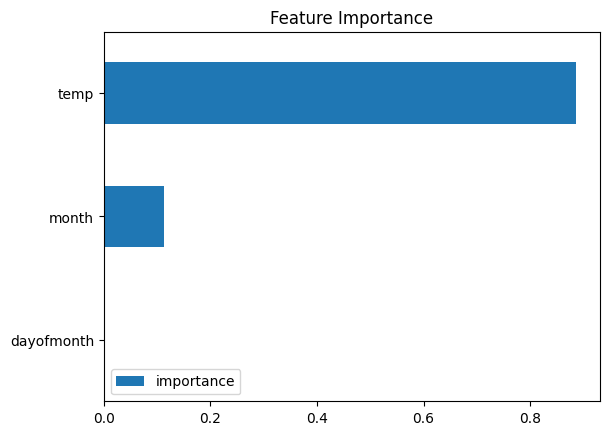

In [53]:
fi_temp = pd.DataFrame(data=reg.feature_importances_,
             index=reg.feature_names_in_,
             columns=['importance'])
fi_temp.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

#### Comparison of Actual vs. Predicted Temperature Data

In [54]:
test_temp['prediction'] = reg.predict(X_test_temp)

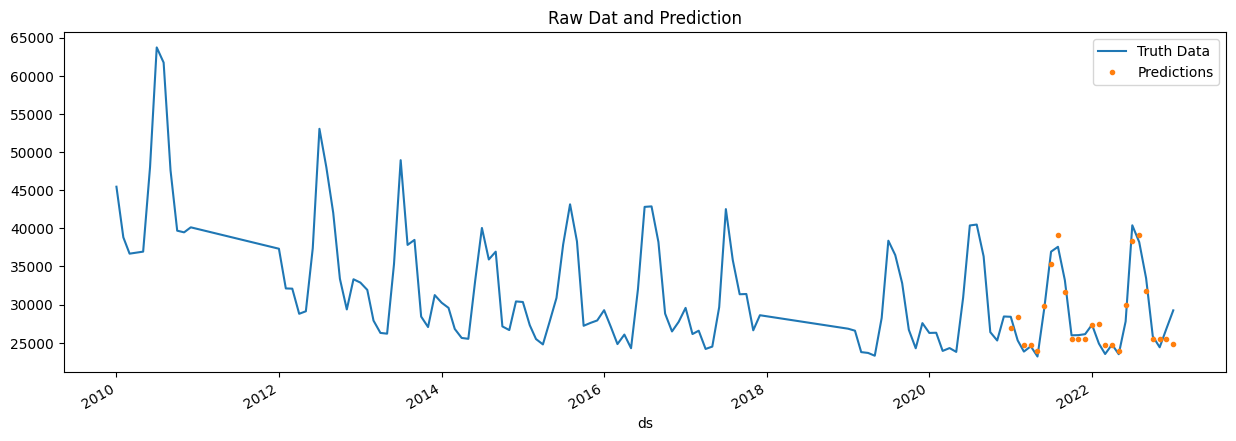

In [55]:
df_monthly_temprature = df_monthly_temprature.merge(test_temp[['prediction']], how='left', left_index=True, right_index=True)
ax = df_monthly_temprature[['y']].plot(figsize=(15, 5))
df_monthly_temprature['prediction'].plot(ax=ax, style='.')
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw Dat and Prediction')
plt.show()

# Model Evaluation

In [56]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

score = np.sqrt(mean_squared_error(test_temp['y'], test_temp['prediction']))
r2= r2_score(test_temp['y'], test_temp['prediction'])
mae= mean_absolute_error(test_temp['y'], test_temp['prediction'])
mape=mean_absolute_percentage_error(y_true=test_temp['y'], y_pred=test_temp['prediction'])
print(f'MSE : {score:0.2f}')
print(f'R2 Error : {r2:0.2f}')
print(f'MAE : {mae:0.2f}') 
print(f'MAPE : {mape:0.2f}') 

MSE : 1604.19
R2 Error : 0.90
MAE : 1238.63
MAPE : 4.32


#### Top 10 Dates by Mean Absolute Error Evaluation

In [57]:
test_temp['error'] = np.abs(test_temp[TARGET] - test_temp['prediction'])
test_temp['date'] = test_temp.index.date
test_temp.groupby(['date'])['error'].mean().sort_values(ascending=False).head(10)

date
2023-01-01    4409.027000
2021-02-01    3126.961419
2022-02-01    2546.485688
2022-06-01    2132.633054
2022-07-01    2082.404976
2022-09-01    1700.183179
2021-07-01    1592.728802
2021-08-01    1592.156588
2021-09-01    1492.328928
2021-01-01    1466.424126
Name: error, dtype: float64

# Part-4

# Yearly Consumption

In [58]:
df_yearly = df[['Consumption (KWH)', 'Revenue Month']]
df_yearly['avg_by_year'] = df.groupby(df['Revenue Month'].dt.year)['Consumption (KWH)'].transform('mean')
df_yearly['Year'] = df_yearly['Revenue Month'].dt.year
df_yearly = df_yearly[['avg_by_year','Year']]
df_yearly.columns = ['y','ds']
df_yearly = df_yearly.drop_duplicates(keep='first').reset_index(drop=True)
df_yearly['ds'] = pd.to_datetime(df_yearly['ds'], format='%Y')

/var/folders/lh/cswt7s450g10kh_jxldflrlc0000gn/T/ipykernel_2139/1124623150.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_yearly['avg_by_year'] = df.groupby(df['Revenue Month'].dt.year)['Consumption (KWH)'].transform('mean')
/var/folders/lh/cswt7s450g10kh_jxldflrlc0000gn/T/ipykernel_2139/1124623150.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_yearly['Year'] = df_yearly['Revenue Month'].dt.year


In [59]:
df_yearly

,y,ds
0,44612.137796,2010-01-01
1,36346.207317,2012-01-01
2,32702.755515,2013-01-01
3,30694.267709,2014-01-01
4,30726.874515,2015-01-01
5,30849.120661,2016-01-01
6,29747.362545,2017-01-01
7,28191.254194,2019-01-01
8,28353.656726,2020-01-01
9,28162.642161,2021-01-01


#### Creating a Yearly DataFrame Indexed by Date Column

In [60]:
df_yearly['i'] = df_yearly['ds'].copy()
df_yearly = df_yearly.set_index('i')
df_yearly

,y,ds
i,,
2010-01-01,44612.137796,2010-01-01
2012-01-01,36346.207317,2012-01-01
2013-01-01,32702.755515,2013-01-01
2014-01-01,30694.267709,2014-01-01
2015-01-01,30726.874515,2015-01-01
2016-01-01,30849.120661,2016-01-01
2017-01-01,29747.362545,2017-01-01
2019-01-01,28191.254194,2019-01-01
2020-01-01,28353.656726,2020-01-01


### Train Test Split

In [61]:
train_year = df_yearly.loc[df_yearly.index.year < 2021]
test_year = df_yearly.loc[df_yearly.index.year >= 2021]

#### Generating Yearly Features from Time-Series Data

In [62]:
def create_features_yearly(df_yearly):
    df_yearly = df_yearly.copy() 
    df_yearly['year'] = df_yearly['ds'].dt.year
    return df_yearly

df_yearly = create_features_yearly(df_yearly)

In [63]:
df_yearly

,y,ds,year
i,,,
2010-01-01,44612.137796,2010-01-01,2010
2012-01-01,36346.207317,2012-01-01,2012
2013-01-01,32702.755515,2013-01-01,2013
2014-01-01,30694.267709,2014-01-01,2014
2015-01-01,30726.874515,2015-01-01,2015
2016-01-01,30849.120661,2016-01-01,2016
2017-01-01,29747.362545,2017-01-01,2017
2019-01-01,28191.254194,2019-01-01,2019
2020-01-01,28353.656726,2020-01-01,2020


#### Yearly Feature Engineering and Dataset Preparation

In [64]:
train_year = create_features_yearly(train_year)
test_year = create_features_yearly(test_year)

FEATURES_year = ['year']
TARGET_year = 'y'

X_train_year = train_year[FEATURES_year]
y_train_year = train_year[TARGET_year]

X_test_year = test_year[FEATURES_year]
y_test_year = test_year[TARGET_year]

### Training an XGBoost Regressor Model

In [65]:
reg = xgb.XGBRegressor()
reg.fit(X_train_year, y_train_year,
        eval_set=[(X_train_year, y_train_year), (X_test_year, y_test_year)],
        verbose=100)

[0]	validation_0-rmse:4055.90942	validation_1-rmse:3232.68619
[99]	validation_0-rmse:0.00537	validation_1-rmse:520.36922


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

### Comparison of Actual Data and Predictions for the Year

In [66]:
test_year['prediction'] = reg.predict(X_test_year)

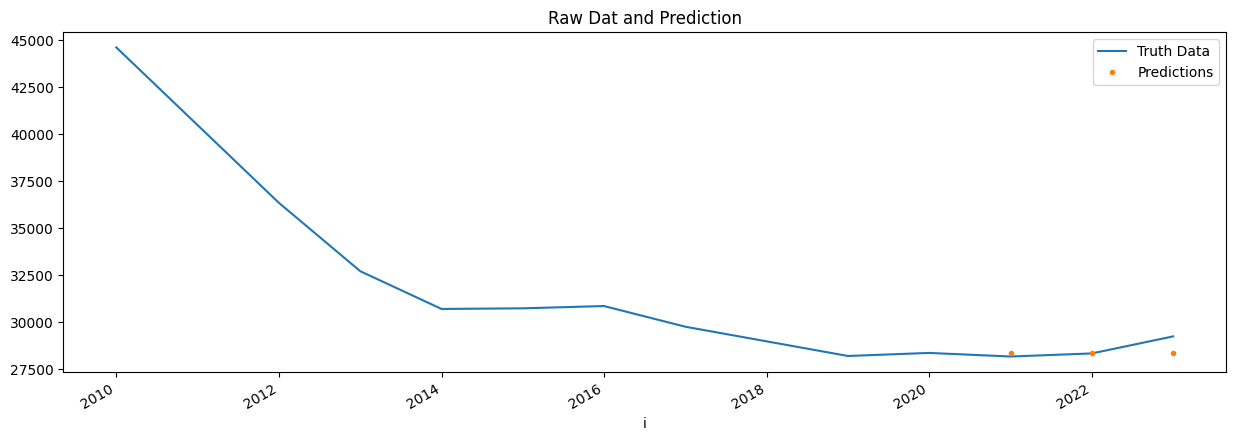

In [67]:
df_yearly = df_yearly.merge(test_year[['prediction']], how='left', left_index=True, right_index=True)
ax = df_yearly[['y']].plot(figsize=(15, 5))
df_yearly['prediction'].plot(ax=ax, style='.')
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw Dat and Prediction')
plt.show()

# Model Evaluation

In [68]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

score = np.sqrt(mean_squared_error(test_year['y'], test_year['prediction']))
r2= r2_score(test_year['y'], test_year['prediction'])
mae= mean_absolute_error(test_year['y'], test_year['prediction'])
mape=mean_absolute_percentage_error(y_true=test_year['y'], y_pred=test_year['prediction'])
print(f'MSE : {score:0.2f}')
print(f'R2 Error : {r2:0.2f}')
print(f'MAE : {mae:0.2f}') 
print(f'MAPE : {mape:0.2f}') 

MSE : 520.37
R2 Error : -0.22
MAE : 366.05
MAPE : 1.26


# Adding Temprature Data to Original Yearly  data Frame

Extracted yearly average consumption and revenue month data and calculated yearly average consumption and assign year and selected relevant columns, renamed columns, and formated date

In [71]:
df_yearly_temprature = df[['Consumption (KWH)', 'Revenue Month']]
df_yearly_temprature['avg_by_year'] = df.groupby(df['Revenue Month'].dt.year)['Consumption (KWH)'].transform('mean')
df_yearly_temprature['Year'] = df_yearly_temprature['Revenue Month'].dt.year
df_yearly_temprature = df_yearly_temprature[['avg_by_year','Year']]
df_yearly_temprature.columns = ['y','ds']
df_yearly_temprature = df_yearly_temprature.drop_duplicates(keep='first').reset_index(drop=True)
df_yearly_temprature['ds'] = pd.to_datetime(df_yearly_temprature['ds'], format='%Y')

/var/folders/lh/cswt7s450g10kh_jxldflrlc0000gn/T/ipykernel_2139/858390966.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_yearly_temprature['avg_by_year'] = df.groupby(df['Revenue Month'].dt.year)['Consumption (KWH)'].transform('mean')
/var/folders/lh/cswt7s450g10kh_jxldflrlc0000gn/T/ipykernel_2139/858390966.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_yearly_temprature['Year'] = df_yearly_temprature['Revenue Month'].dt.year


#### Added temperature data

In [72]:
df_yearly_temprature['temp'] = [56.7,57.3,55.3,54.4,56.7,57.2,56.3,55.6,57.3,56.9,56.3,59.1]

In [73]:
df_yearly_temprature

,y,ds,temp
0,44612.137796,2010-01-01,56.7
1,36346.207317,2012-01-01,57.3
2,32702.755515,2013-01-01,55.3
3,30694.267709,2014-01-01,54.4
4,30726.874515,2015-01-01,56.7
5,30849.120661,2016-01-01,57.2
6,29747.362545,2017-01-01,56.3
7,28191.254194,2019-01-01,55.6
8,28353.656726,2020-01-01,57.3
9,28162.642161,2021-01-01,56.9


#### Average Yearly Temperature Trends

Text(0.5, 1.0, 'Average Yearly temprature over the years')

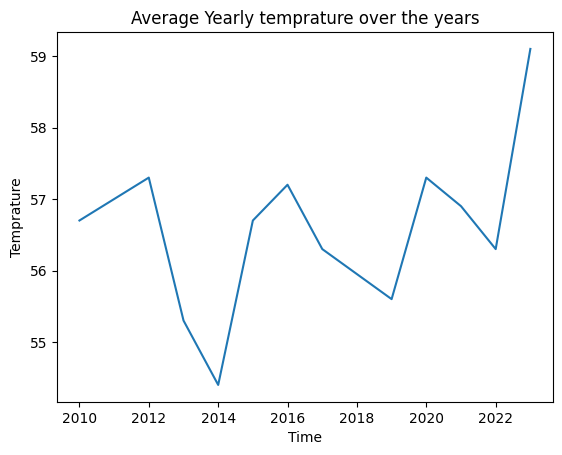

In [74]:
plt.plot( df_yearly_temprature['ds'], df_yearly_temprature['temp'])
plt.xlabel('Time')
plt.ylabel('Temprature')
plt.title('Average Yearly temprature over the years')

#### Setting 'ds' Column as Index in Yearly Temperature DataFrame

In [75]:
df_yearly_temprature = df_yearly_temprature.set_index('ds')
df_yearly_temprature

,y,temp
ds,,
2010-01-01,44612.137796,56.7
2012-01-01,36346.207317,57.3
2013-01-01,32702.755515,55.3
2014-01-01,30694.267709,54.4
2015-01-01,30726.874515,56.7
2016-01-01,30849.120661,57.2
2017-01-01,29747.362545,56.3
2019-01-01,28191.254194,55.6
2020-01-01,28353.656726,57.3


### Train test split

In [76]:
train_yearly_temp = df_yearly_temprature.loc[df_yearly_temprature.index.year < 2021]
test_yearly_temp = df_yearly_temprature.loc[df_yearly_temprature.index.year >= 2021]

#### Adding Yearly Temperature Features

In [77]:
def create_features_yealry_temprature(df_yearly_temprature):
    df_yearly_temprature = df_yearly_temprature.copy() 
    df_yearly_temprature['month'] = df_yearly_temprature.index.month
    df_yearly_temprature['dayofmonth'] = df_yearly_temprature.index.day
    df_yearly_temprature['year'] = df_yearly_temprature.index.year
    return df_yearly_temprature

df_yearly_temprature = create_features_yealry_temprature(df_yearly_temprature)
df_yearly_temprature

,y,temp,month,dayofmonth,year
ds,,,,,
2010-01-01,44612.137796,56.7,1,1,2010
2012-01-01,36346.207317,57.3,1,1,2012
2013-01-01,32702.755515,55.3,1,1,2013
2014-01-01,30694.267709,54.4,1,1,2014
2015-01-01,30726.874515,56.7,1,1,2015
2016-01-01,30849.120661,57.2,1,1,2016
2017-01-01,29747.362545,56.3,1,1,2017
2019-01-01,28191.254194,55.6,1,1,2019
2020-01-01,28353.656726,57.3,1,1,2020


In [78]:
train_yearly_temp = create_features_yealry_temprature(train_yearly_temp)
test_yearly_temp = create_features_yealry_temprature(test_yearly_temp)

FEATURES_TEMP_yearly = ['year','temp']
TARGET_TEMP_yealry = 'y'

X_train_temp_yearly = train_yearly_temp[FEATURES_TEMP_yearly]
y_train_temp_yealry = train_yearly_temp[TARGET_TEMP_yealry]

X_test_temp_yearly = test_yearly_temp[FEATURES_TEMP_yearly]
y_test_temp_yearly = test_yearly_temp[TARGET_TEMP_yealry]

#### XGBoost Regression : Predicting Yearly Temperature Trends

In [84]:
reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                       n_estimators=1000,
                       early_stopping_rounds=50,
                       objective='reg:squarederror',
                       max_depth=3,
                       learning_rate=0.01)
reg.fit(X_train_temp_yearly, y_train_temp_yealry,
        eval_set=[(X_train_temp_yearly, y_train_temp_yealry), (X_test_temp_yearly, y_test_temp_yearly)],
        verbose=100)

[0]	validation_0-rmse:32543.95597	validation_1-rmse:28285.76499
[100]	validation_0-rmse:13911.41280	validation_1-rmse:9146.23391
[200]	validation_0-rmse:6802.14392	validation_1-rmse:2978.48796
[300]	validation_0-rmse:3695.35375	validation_1-rmse:1458.68341
[400]	validation_0-rmse:2117.67041	validation_1-rmse:912.96992
[500]	validation_0-rmse:1248.95881	validation_1-rmse:651.91230
[600]	validation_0-rmse:749.17239	validation_1-rmse:587.34691
[700]	validation_0-rmse:452.75577	validation_1-rmse:548.36132
[800]	validation_0-rmse:274.17381	validation_1-rmse:527.47371
[900]	validation_0-rmse:166.33418	validation_1-rmse:518.31078
[999]	validation_0-rmse:101.76903	validation_1-rmse:514.14773


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

#### Yearly Temperature: Actual vs Predicted Data

In [87]:
test_yearly_temp['prediction'] = reg.predict(X_test_temp_yearly)

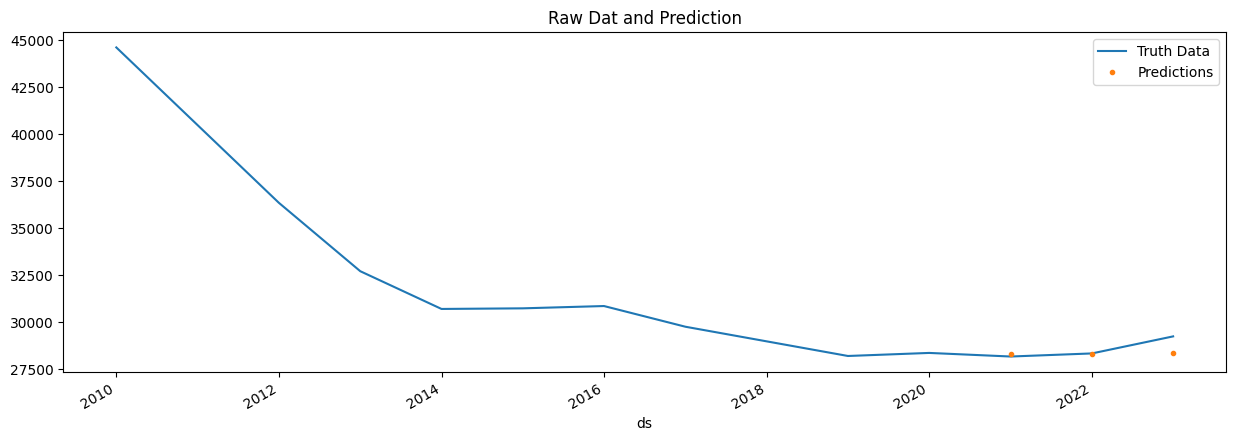

In [88]:
df_yearly_temprature = df_yearly_temprature.merge(test_yearly_temp[['prediction']], how='left', left_index=True, right_index=True)
ax = df_yearly_temprature[['y']].plot(figsize=(15, 5))
df_yearly_temprature['prediction'].plot(ax=ax, style='.')
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw Dat and Prediction')
plt.show()

# Model Evaluation

In [89]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

score = np.sqrt(mean_squared_error(test_yearly_temp['y'], test_yearly_temp['prediction']))
r2= r2_score(test_yearly_temp['y'], test_yearly_temp['prediction'])
mae= mean_absolute_error(test_yearly_temp['y'], test_yearly_temp['prediction'])
mape=mean_absolute_percentage_error(y_true=test_yearly_temp['y'], y_pred=test_yearly_temp['prediction'])
print(f'MSE : {score:0.2f}')
print(f'R2 Error : {r2:0.2f}')
print(f'MAE : {mae:0.2f}') 
print(f'MAPE : {mape:0.2f}') 

MSE : 514.15
R2 Error : -0.19
MAE : 348.24
MAPE : 1.20


# Electric Consumption Prediction for Individual Boroughs

Generated time series forecasts for electricity consumption (KWH) in different boroughs of New York City using an XGBoost regression model. 
Created a DataFrame 'df_borough' to calculate the mean consumption per month for each borough.
Prepared data for modeling by transforming datetime features and trained an XGBoost regression model for each borough and generated forecasts for the next 3 years (36 months) for each borough.

In [90]:
df_borough = pd.DataFrame()
df_borough['y'] = df[['Borough', 'Revenue Month', 'Consumption (KWH)']].groupby(['Borough', 'Revenue Month']).transform('mean')
df_borough['ds'] = df['Revenue Month']
df_borough['Borough'] = df['Borough']
df_borough = df_borough.reset_index(drop=True)

#### Plotted actual consumption data along with forecasted values for visual comparison per borough.

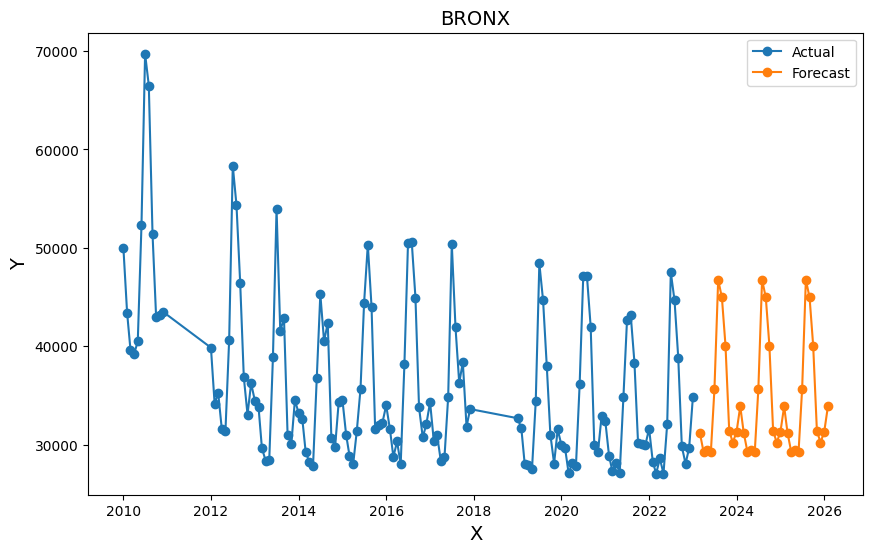

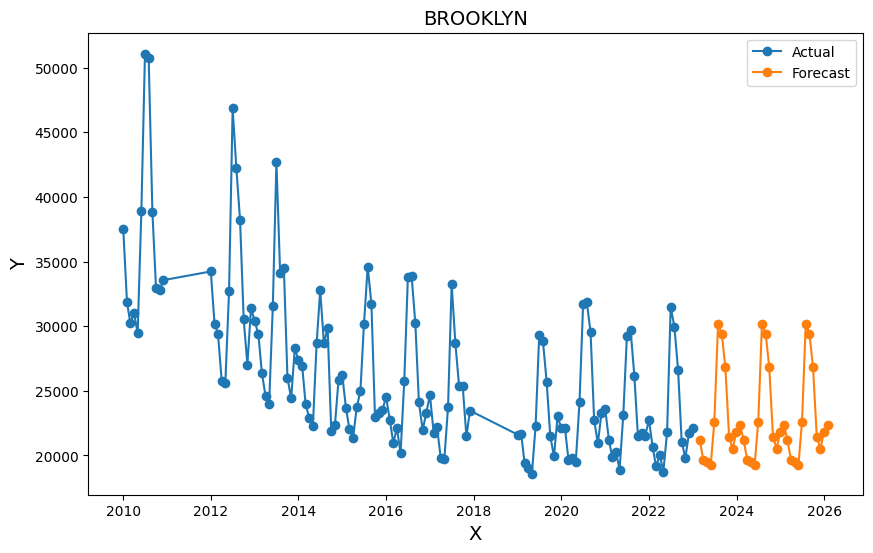

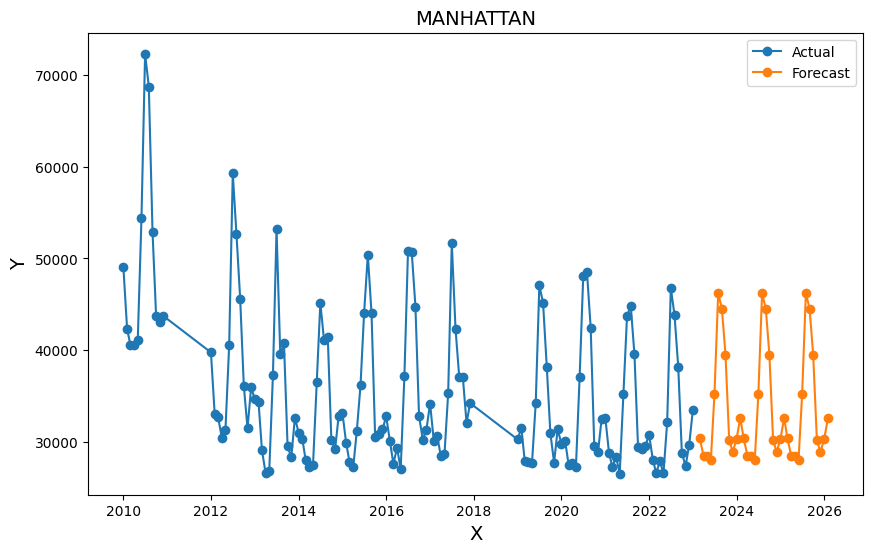

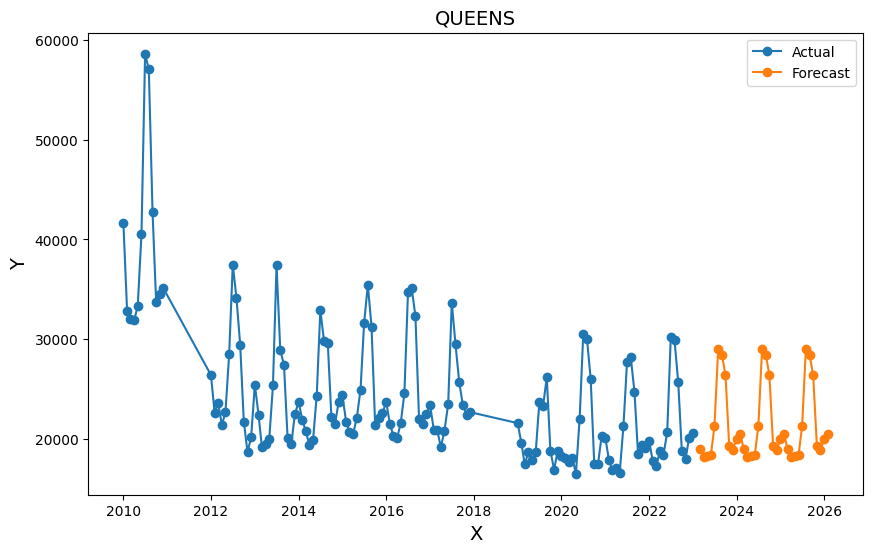

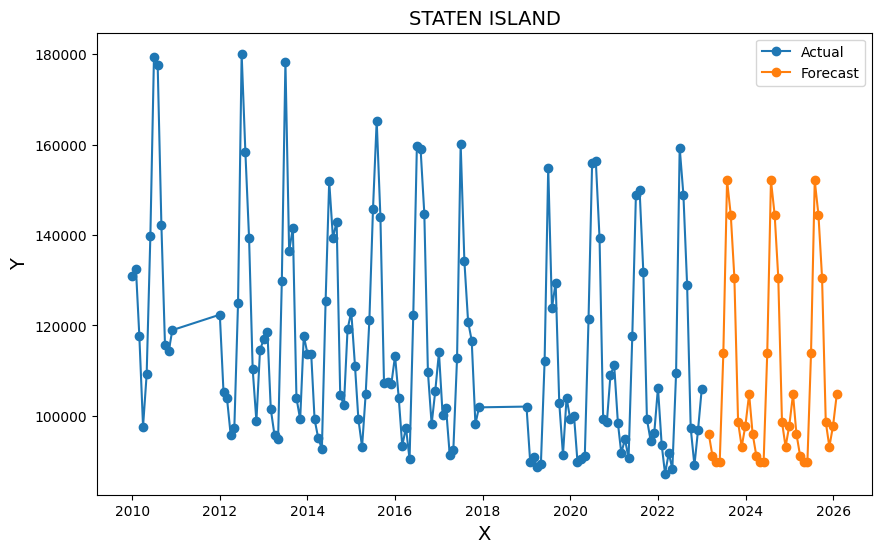

In [91]:
for borough in ['BRONX', 'BROOKLYN', 'MANHATTAN', 'QUEENS', 'STATEN ISLAND']:
    x = df_borough[df_borough['Borough'] == borough][['y', 'ds']].drop_duplicates(keep='first')
    
    x['ds'] = pd.to_datetime(x['ds'])
    x['ds_numeric'] = (x['ds'] - x['ds'].min()) / np.timedelta64(1, 'D')
    x['month'] = x['ds'].dt.month
    x['year'] = x['ds'].dt.year
    
    X = x[['ds_numeric', 'month', 'year']]
    y = x['y']
    
    model = xgb.XGBRegressor(
        objective='reg:squarederror',
        n_estimators=100,
        max_depth=3,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8
    )
    
    model.fit(X, y)
    
    future_months = pd.date_range(start=x['ds'].max(), periods=12*3 + 1, freq='M')[1:]  # Start from the next month
    future = pd.DataFrame({'ds': future_months})
    future['ds_numeric'] = (future['ds'] - x['ds'].min()) / np.timedelta64(1, 'D')
    future['month'] = future['ds'].dt.month
    future['year'] = future['ds'].dt.year
    
    forecast = model.predict(future[['ds_numeric', 'month', 'year']])
    
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.plot(x['ds'], y, label='Actual', marker='o')
    ax.plot(future['ds'], forecast, label='Forecast', marker='o')
    ax.set_title(borough, size=14)
    ax.set_xlabel("X", size=14)
    ax.set_ylabel("Y", size=14)
    ax.legend()

plt.show()


# XGBoost time series forecasting vs FBProphet forecasting